# Libraries


In [25]:
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    StratifiedKFold,
    RepeatedStratifiedKFold
)
from sklearn.preprocessing import ( 
    OneHotEncoder
)
from sklearn.compose import (
    ColumnTransformer,
)
from optuna.visualization import (
    plot_optimization_history, 
    plot_param_importances, 
    plot_slice
)
from sklearn.pipeline import Pipeline

from sklearn import set_config
from typing import List, Tuple
from glob import glob

import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap

# Configuration


In [27]:
# Global configurations for sklearn:
set_config(transform_output="pandas")

# Global configurations for pandas:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
pd.set_option("display.precision", 3)
pd.set_option("display.max_colwidth", None)

# Global configurations for polars:
pl.Config.activate_decimals(True).set_tbl_hide_column_data_types(True)
pl.Config(
    **dict(
        tbl_formatting="ASCII_FULL_CONDENSED",
        tbl_hide_column_data_types=False,
        tbl_hide_dataframe_shape=True,
        fmt_float="mixed",
        tbl_cell_alignment="CENTER",
        tbl_hide_dtype_separator=True,
        tbl_cols=100,
        tbl_rows=50,
        fmt_str_lengths=100,
    )
)

In [24]:
ROOT_DIR = "data/"
TRAIN_DIR = ROOT_DIR + "train/"
TEST_DIR = ROOT_DIR + "test/"

SEED = 42

# Functions


In [4]:
class DataFrameProcessor:
    """Dataframe processing class."""

    @staticmethod
    def convert_types(df: pl.DataFrame) -> pl.DataFrame:
        """Converts columns' data types for memory.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        for column in df.columns:
            if column == "target":
                df = df.with_columns(pl.col(column).cast(pl.Int8))
            elif column in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(column).cast(pl.Int32))
            elif column == "date_decision":
                df = df.with_columns(pl.col(column).cast(pl.Date))
            elif column[-1] in ("P", "A"):
                df = df.with_columns(pl.col(column).cast(pl.Float64))
            elif column[-1] == "M":
                df = df.with_columns(pl.col(column).cast(pl.String))
            elif column[-1] == "D":
                df = df.with_columns(pl.col(column).cast(pl.Date))

        return df

    @staticmethod
    def date_processor(df: pl.DataFrame) -> pl.DataFrame:
        """Processes the date columns.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        for column in df.columns:
            if column[-1] == "D":
                df = df.with_columns(pl.col(column) - pl.col("date_decision"))
                df = df.with_columns(pl.col(column).dt.total_days())
                df = df.with_columns(pl.col(column).cast(pl.Float32))

            if column == "date_decision":
                df = df.with_columns(
                    pl.col(column).dt.year().alias("year_decision"),
                    pl.col(column).dt.month().alias("month_decision"),
                    pl.col(column).dt.day().alias("day_decision"),
                    pl.col(column).dt.week().alias("week_decision"),
                    pl.col(column).dt.weekday().alias("weekday_decision"),
                    pl.col(column).dt.quarter().alias("quarter_decision"),
                )

        df = df.drop(["date_decision", "WEEK_NUM", "MONTH"])

        return df

    @staticmethod
    def delete_nulls_column(df: pl.DataFrame) -> pl.DataFrame:
        """Deletes columns with more than 80% of null values.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        for column in df.columns:
            if column not in ["case_id", "target"]:
                null_percentage = df[column].is_null().sum() / df.shape[0]

                if null_percentage > 0.80:
                    df = df.drop(column)

        return df

    @staticmethod
    def drop_duplicates(df: pl.DataFrame) -> pl.DataFrame:
        """Drops duplicates from the DataFrame.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        df = df.unique(keep="first")

        return df

    @staticmethod
    def drop_columns_with_too_many_categories(df: pl.DataFrame) -> pl.DataFrame:
        """Drops columns with more than 100 categories or just 1.

        Argument:
        df (polars dataframe): The DataFrame to be processed.
        """
        for column in df.columns:
            if (column not in ["target", "case_id"]) & (df[column].dtype == pl.String):
                categories_count = df[column].n_unique()

                if (categories_count == 1) | (categories_count > 200):
                    df = df.drop(column)

        return df

In [5]:
class Aggregator:
    """Dataframe aggreagating class."""

    @staticmethod
    def max_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the maximum value.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column[-1] in ("P", "A")]

        expr_max = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_max

    @staticmethod
    def min_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the minimum value.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column[-1] in ("P", "A")]

        expr_min = [pl.min(column).alias(f"min_{column}") for column in columns]

        return expr_min

    @staticmethod
    def date_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the date columns.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column[-1] == "D"]

        expr_date = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_date

    @staticmethod
    def string_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the string columns.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column[-1] == "M"]

        expr_string = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_string

    @staticmethod
    def others_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the other columns.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if column in ("T", "L")]

        expr_others = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_others

    @staticmethod
    def count_agg(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by the count of rows.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        columns = [column for column in df.columns if "num_group" in column]

        expr_max = [pl.max(column).alias(f"max_{column}") for column in columns]

        return expr_max

    @staticmethod
    def agg_expr(df: pl.DataFrame) -> pl.Expr:
        """Aggregates the DataFrame by all the columns.

        Argument:
        df (polars dataframe): The DataFrame to be aggregated.
        """
        expr_all = (
            Aggregator.max_agg(df)
            + Aggregator.min_agg(df)
            + Aggregator.date_agg(df)
            + Aggregator.string_agg(df)
            + Aggregator.others_agg(df)
            + Aggregator.count_agg(df)
        )
        return expr_all

In [6]:
def read_file(path: str, depth: int = 0) -> pl.DataFrame:
    """Read file from the given path.

    Arguments:
    path (str): The path to the file.
    depth (int): The depth of the file.
    """
    df = pl.read_parquet(path)
    df = df.pipe(DataFrameProcessor.convert_types)

    if depth in (1, 2):
        df = df.group_by("case_id").agg(Aggregator.agg_expr(df))

    return df


def read_files(path: str, depth: int = 0) -> pl.DataFrame:
    """Read multiple files from the given path and concatenate them vertically.

    Arguments:
    path (str): The path to the files.
    depth (int): The depth of the file.
    """
    chunks = []
    for one_path in glob(path):
        df = read_file(one_path, depth)
        chunks.append(df)

    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.pipe(DataFrameProcessor.drop_duplicates)

    return df


def merge_dataframe(df_base: pl.DataFrame, **depths: dict) -> pl.DataFrame:
    """Join multiple dataframes together.

    Arguments:
    df_base (pl.DataFrame): The base DataFrame.
    **depths (dict of lists of pl.DataFrame): Named groups of DataFrames to join with df_base.
    """
    index = 0
    for _, depth_group in depths.items():
        for df in depth_group:
            if df is not None:
                df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{index}")
                index += 1

    # Here you would integrate any post-join operations if necessary
    df_base = df_base.pipe(DataFrameProcessor.date_processor)

    return df_base


def convert_to_pandas_df(
    polars_df: pl.DataFrame, category_columns: List[str] = None
) -> Tuple[pd.DataFrame, List[str]]:
    pandas_df = polars_df.to_pandas()

    # Apply the same set of column to the test set
    if category_columns is None:
        category_columns = list(pandas_df.select_dtypes(include=["object"]).columns)

    # Convert to category for ML
    pandas_df[category_columns] = pandas_df[category_columns].astype("category")

    return pandas_df, category_columns

In [7]:
def convert_to_pandas_df(
    polars_df: pl.DataFrame, category_columns: List[str] = None
) -> Tuple[pd.DataFrame, List[str]]:
    pandas_df = polars_df.to_pandas()

    # Apply the same set of column to the test set
    if category_columns is None:
        category_columns = list(pandas_df.select_dtypes(include=["object"]).columns)

    # Convert to category for ML
    pandas_df[category_columns] = pandas_df[category_columns].astype("category")

    return pandas_df, category_columns

# Read Data


In [8]:
%%time
# Test pandas reading time
test_pandas_df = pd.read_parquet('data/train/train_base.parquet')
test_pandas_df.head()

CPU times: user 75.4 ms, sys: 30.9 ms, total: 106 ms
Wall time: 95.1 ms


,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1


In [9]:
%%time
test_polars_df = pl.read_parquet('data/train/train_base.parquet')
display(test_polars_df.head())

case_id,date_decision,MONTH,WEEK_NUM,target
i64,str,i64,i64,i64
0,"""2019-01-03""",201901,0,0
1,"""2019-01-03""",201901,0,0
2,"""2019-01-04""",201901,0,0
3,"""2019-01-03""",201901,0,0
4,"""2019-01-04""",201901,0,1


CPU times: user 48.1 ms, sys: 23.4 ms, total: 71.5 ms
Wall time: 39.7 ms


> Comment: Polars read data faster than pandas, since there are many files, it might be a good idea for me to mitigate to Polars.


In [10]:
test_df = read_file(TRAIN_DIR + "train_base.parquet")
test_df.head()

case_id,date_decision,MONTH,WEEK_NUM,target
i32,date,i64,i32,i8
0,2019-01-03,201901,0,0
1,2019-01-03,201901,0,0
2,2019-01-04,201901,0,0
3,2019-01-03,201901,0,0
4,2019-01-04,201901,0,1


In [11]:
%%time
train_dict = {
    "df_base": read_file(TRAIN_DIR + "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR + "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR + "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR + "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR + "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR + "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR + "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR + "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR + "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR + "train_other_1.parquet", 1),
        read_file(TRAIN_DIR + "train_person_1.parquet", 1),
        read_file(TRAIN_DIR + "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR + "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR + "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR + "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

CPU times: user 1min 41s, sys: 35.3 s, total: 2min 17s
Wall time: 41 s


In [12]:
%%time
train_master = merge_dataframe(**train_dict)
train_df = train_master.pipe(DataFrameProcessor.delete_nulls_column).pipe(DataFrameProcessor.drop_columns_with_too_many_categories)

CPU times: user 8.02 s, sys: 2.9 s, total: 10.9 s
Wall time: 4.02 s


In [13]:
%%time
test_dict = {
    "df_base": read_file(TEST_DIR + "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR + "test_static_cb_0.parquet"),
        read_files(TEST_DIR + "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR + "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR + "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR + "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR + "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR + "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR + "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR + "test_other_1.parquet", 1),
        read_file(TEST_DIR + "test_person_1.parquet", 1),
        read_file(TEST_DIR + "test_deposit_1.parquet", 1),
        read_file(TEST_DIR + "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR + "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR + "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

CPU times: user 50 ms, sys: 29.2 ms, total: 79.2 ms
Wall time: 116 ms


In [14]:
%%time
test_df = merge_dataframe(**test_dict)
test_df = test_df.select([column for column in train_df.columns if column != "target"])

CPU times: user 17.4 ms, sys: 8.28 ms, total: 25.7 ms
Wall time: 29.4 ms


In [15]:
%%time
train_df, used_category_columns = convert_to_pandas_df(train_df)
test_df, _ = convert_to_pandas_df(test_df, used_category_columns)

CPU times: user 4.34 s, sys: 1.92 s, total: 6.26 s
Wall time: 5.09 s


# Exploratory Data Analysis

In [19]:
train_df.head()

,case_id,target,birthdate_574D,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avginstallast24m_3658937A,avgmaxdpdlast9m_3716943P,avgoutstandbalancel6m_4187114A,avgpmtlast12m_4525200A,bankacctype_710L,clientscnt12m_3712952L,clientscnt3m_3712950L,clientscnt6m_3712949L,clientscnt_100L,clientscnt_1022L,clientscnt_1071L,clientscnt_1130L,clientscnt_157L,clientscnt_257L,clientscnt_304L,clientscnt_360L,clientscnt_493L,clientscnt_533L,clientscnt_887L,clientscnt_946L,cntincpaycont9m_3716944L,cntpmts24_3658933L,commnoinclast6m_3546845L,credamount_770A,credtype_322L,currdebt_22A,currdebtcredtyperange_828A,datefirstoffer_1144D,datelastunpaid_3546854D,daysoverduetolerancedd_3976961L,deferredmnthsnum_166L,disbursedcredamount_1113A,disbursementtype_67L,downpmt_116A,dtlastpmtallstes_4499206D,eir_270L,firstclxcampaign_1125D,firstdatedue_489D,homephncnt_628L,inittransactioncode_186L,interestrate_311L,isbidproduct_1095L,lastactivateddate_801D,lastapplicationdate_877D,lastapprcommoditycat_1041M,lastapprcredamount_781A,lastapprdate_640D,lastcancelreason_561M,lastdelinqdate_224D,lastrejectcommoditycat_161M,lastrejectcommodtypec_5251769M,lastrejectcredamount_222A,lastrejectdate_50D,lastrejectreason_759M,lastrejectreasonclient_4145040M,lastst_736L,maininc_215A,mastercontrelectronic_519L,mastercontrexist_109L,maxannuity_159A,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdebt4_972A,maxdpdfrom6mto36m_3546853P,maxdpdinstldate_3546855D,maxdpdinstlnum_3546846P,maxdpdlast12m_727P,maxdpdlast24m_143P,maxdpdlast3m_392P,maxdpdlast6m_474P,maxdpdlast9m_1059P,maxdpdtolerance_374P,maxinstallast24m_3658928A,maxlnamtstart6m_4525199A,maxoutstandbalancel12m_4187113A,maxpmtlast3m_4525190A,mindbddpdlast24m_3658935P,mindbdtollast24m_4525191P,mobilephncnt_593L,monthsannuity_845L,numactivecreds_622L,numactivecredschannel_414L,numactiverelcontr_750L,numcontrs3months_479L,numincomingpmts_3546848L,numinstlallpaidearly3d_817L,numinstls_657L,numinstlsallpaid_934L,numinstlswithdpd10_728L,numinstlswithdpd5_4187116L,numinstlswithoutdpd_562L,numinstmatpaidtearly2d_4499204L,numinstpaid_4499208L,numinstpaidearly3d_3546850L,numinstpaidearly3dest_4493216L,numinstpaidearly5d_1087L,numinstpaidearly5dest_4493211L,numinstpaidearly5dobd_4499205L,numinstpaidearly_338L,numinstpaidearlyest_4493214L,numinstpaidlastcontr_4325080L,numinstpaidlate1d_3546852L,numinstregularpaid_973L,numinstregularpaidest_4493210L,numinsttopaygr_769L,numinsttopaygrest_4493213L,numinstunpaidmax_3546851L,numinstunpaidmaxest_4493212L,numnotactivated_1143L,numpmtchanneldd_318L,numrejects9m_859L,opencred_647L,paytype1st_925L,paytype_783L,pctinstlsallpaidearl3d_427L,pctinstlsallpaidlat10d_839L,pctinstlsallpaidlate1d_3546856L,pctinstlsallpaidlate4d_3546849L,pctinstlsallpaidlate6d_3546844L,pmtnum_254L,posfpd10lastmonth_333P,posfpd30lastmonth_3976960P,posfstqpd30lastmonth_3976962P,price_1097A,sellerplacecnt_915L,sellerplacescnt_216L,sumoutstandtotal_3546847A,sumoutstandtotalest_4493215A,totaldebt_9A,totalsettled_863A,totinstallast1m_4525188A,twobodfilling_608L,typesuite_864L,max_actualdpd_943P,max_annuity_853A,max_credacc_credlmt_575A,max_credamount_590A,max_currdebt_94A,max_downpmt_134A,max_mainoccupationinc_437A,max_maxdpdtolerance_577P,max_outstandingdebt_522A,min_actualdpd_943P,min_annuity_853A,min_credacc_credlmt_575A,min_credamount_590A,min_currdebt_94A,min_downpmt_134A,min_m

In [18]:
print(f'Train set shape: {train_df.shape}')

Train set shape: (1526659, 318)


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 318 entries, case_id to quarter_decision
dtypes: bool(1), category(48), float32(38), float64(222), int32(3), int8(6)
memory usage: 2.8 GB


## Target variable

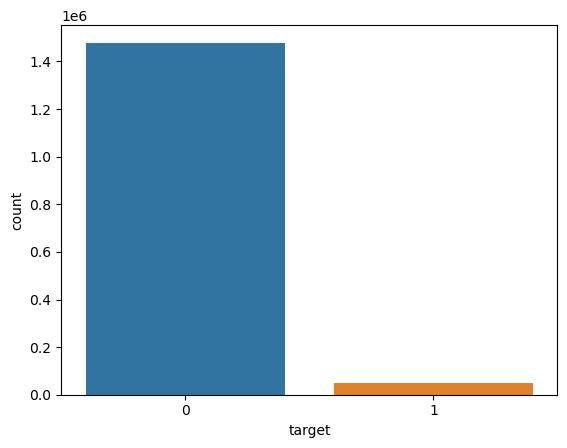

In [20]:
sns.countplot(data=train_df, x='target')
plt.show()

# Pre-processing

In [23]:
features = train_df.drop(['case_id', 'target'], axis=1)
target = train_df['target']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, random_state=SEED, stratify=target, shuffle=True
)

# Check the shape of the train and test data
print(f"Train data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")

Train data shape: (1373993, 316), (1373993,)
Test data shape: (152666, 316), (152666,)


# Modeling

In [28]:
# Cross-validation split
fold = StratifiedKFold(shuffle=True, random_state=SEED)

# Reference

- [Home Credit Baseline](https://www.kaggle.com/code/greysky/home-credit-baseline)
